# Aula 6 - Ciência de Dados: Seleção e ajuste de modelos

Francisco Aparecido Rodrigues, francisco@icmc.usp.br.<br>
Universidade de São Paulo, São Carlos, Brasil.<br>
https://sites.icmc.usp.br/francisco <br>
Copyright: Creative Commons

<hr>

Em muitos métodos de classificação e regressão, precisamos definir os valores dos hiperparâmetros dos modelos, que são parâmetros ajustados pelo usuário. Exemplos desses métodos são o algoritmo k-vizinhos, onde precisamos definir o valor $k$, e o número de árvores no algoritmo florestas aleatórias. No caso de regressão, o desafio é identificar as variáveis mais significativas. Além disso, quando vamos selecionar modelos, é importante que usemos os mesmos conjuntos de dados de forma a termos uma comparação justa. Nessa aula, vamos aprender some seleção e ajuste modelos.

## Classificação

Se dividirmos o conjunto de dados em apenas duas partes, uma teste e outra para treinamento, método chamado **holdout**, depedendo da execução do classificador, podemos obter diferentes resultados. A seguir, mostramos o desempenho do classificar knn de acordo com a execução. Notem que os valores se distribuem de acordo com uma distribuição de probabilidades que se aproxima de uma distribuição Gaussiana.

Acuracia media: 0.54685625


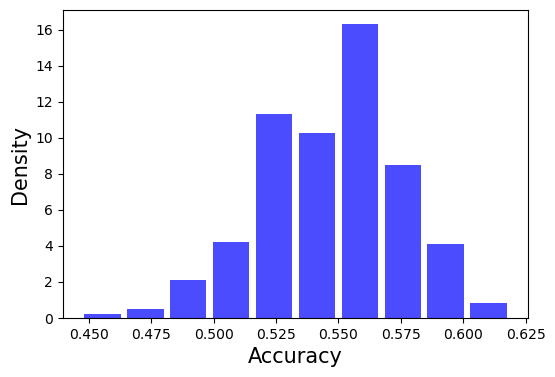

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

#data = pd.read_csv('data/vertebralcolumn-3C.csv', header=(0))
#data = pd.read_csv('data/Iris.csv', header=(0))
data = pd.read_csv('data/winequality-red.csv', header=(0))

data = data.to_numpy()
nrow,ncol = data.shape
y = data[:,-1]
X = data[:,0:ncol-1]

p = 0.8 # fracao de elementos no conjunto de treinamento
Ns = 500 # numero de execucoes da classificacao
vacc = []
for n in range(0, Ns):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = p)
    model = GaussianNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_pred, y_test)
    vacc.append(score)
print('Acuracia media:', np.mean(vacc))
plt.figure(figsize=(6,4))
plt.hist(vacc, color='blue',alpha=0.7, rwidth=0.85, density= 'True')
plt.xticks(color='k', size=10)
plt.yticks(color='k', size=10)
plt.xlabel('Accuracy', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.show(True)

Portanto, podemos ter uma alta ou baixa acurácia, dependendo da execução. 

Além disso, a escolha dos parâmetros do modelo também é influenciada pela execução. Vamos considerar um exemplo. No classificador k-vizinhos, o hiperparâmetro $k$ influencia na classificação e a escolha do melhor valor de $k$ pode depender da execução, se usar o método hold-out, conforme vemos a seguir.

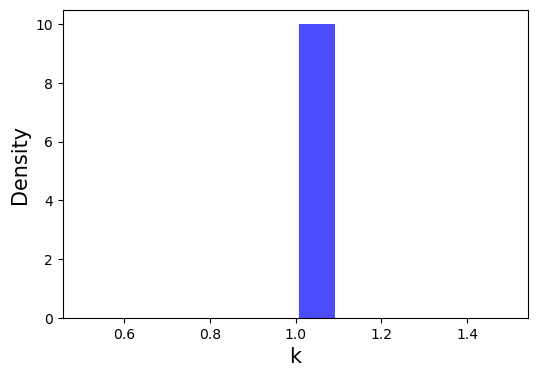

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

#data = pd.read_csv('data/vertebralcolumn-3C.csv', header=(0))
#data = pd.read_csv('data/Iris.csv', header=(0))
data = pd.read_csv('data/winequality-red.csv', header=(0))

data = data.to_numpy()
nrow,ncol = data.shape
y = data[:,-1]
X = data[:,0:ncol-1]

p = 0.8 # fracao de elementos no conjunto de treinamento
Ns = 5 # numero de execucoes da classificacao
vk = []
for n in range(0, Ns):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = p)
    vbest = []
    for k in range(1, 10):
        model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_pred, y_test)
        vbest.append(score)
    vk.append(np.argmax(vbest)+1)    

plt.figure(figsize=(6,4))
plt.hist(vk, color='blue',alpha=0.7, rwidth=0.85, density= 'True')
plt.xticks(color='k', size=10)
plt.yticks(color='k', size=10)
plt.xlabel('k', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.show(True)

Portanto, dependendo da execução, podemos encontrar um valor diferente para $k$, de modo a obter a melhor acurácia. Logo, não podemos obter o melhor modelo de uma maneira adequada.

Para evitarmos essa dependência da execução e diminuirmos a variância, podemos usar os métodos de validação cruzada. Nesse método, dividimos os dados de treinamento em fold (grupos) de tamanho fixo, onde usamos k-1 folds para treinamento e um deles para validação, conforme a figura abaixo. Usamos todas as configurações possíveis.

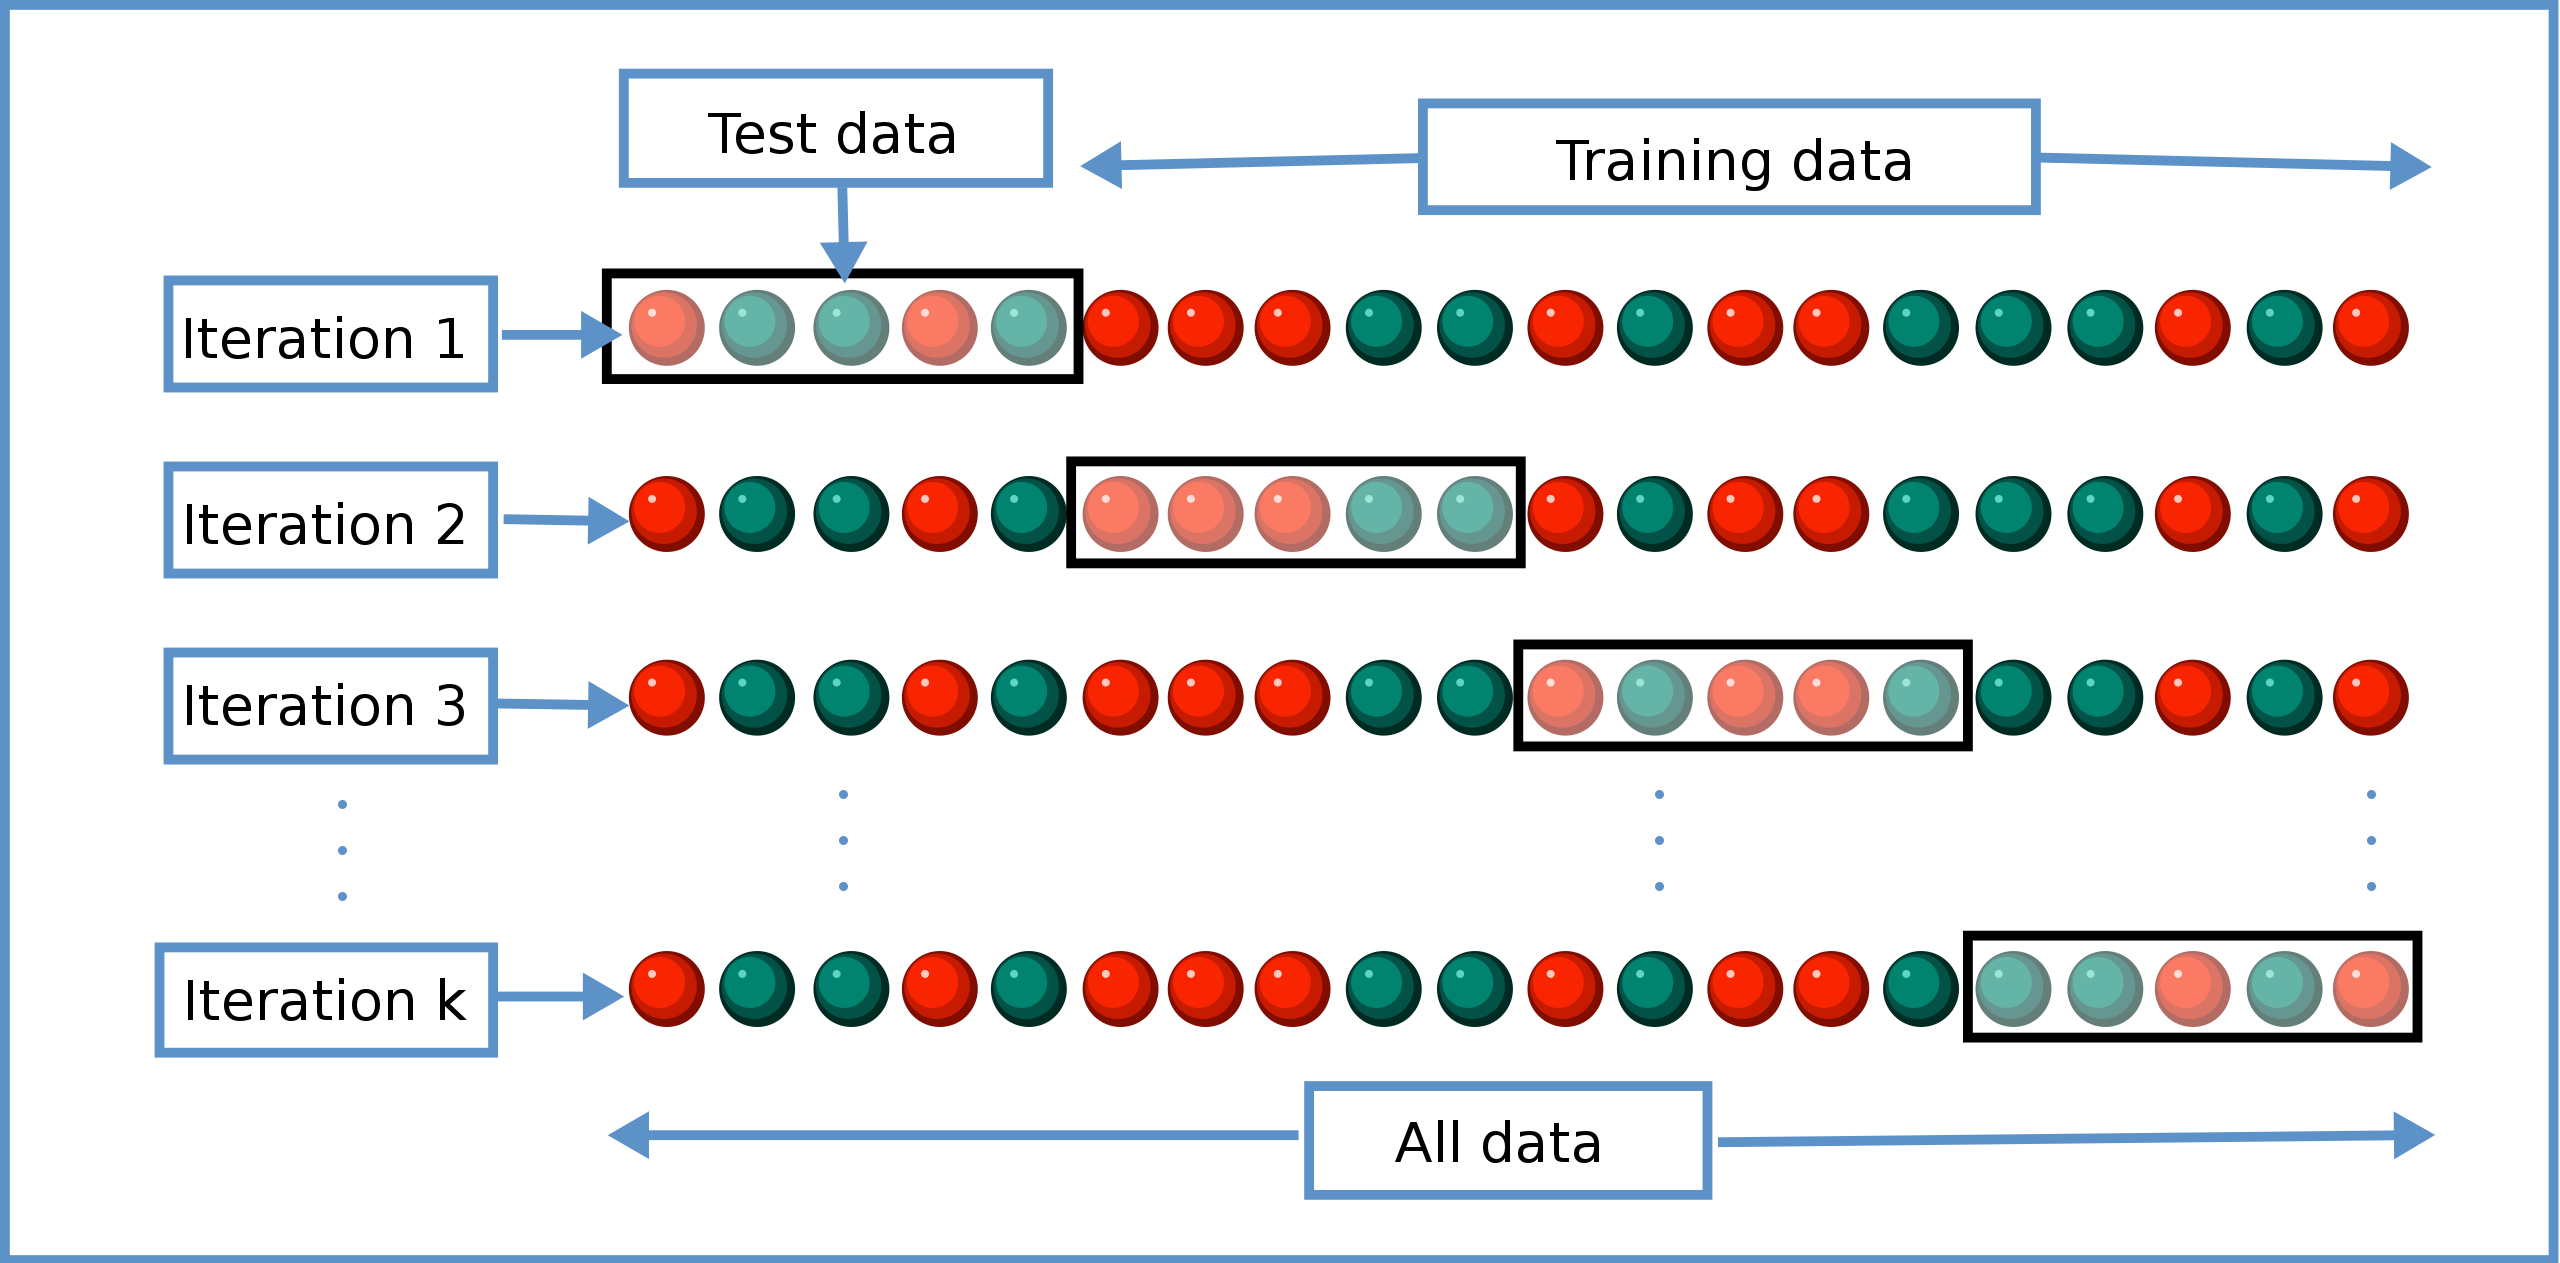

Vamos usar o método de validação cruzada na prática.

In [3]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=10) # cria a sequência de folds
vacc = []
for train_index, test_index in cv.split(X, y):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = GaussianNB()
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test) 
    score = accuracy_score(y_pred, y_test)
    print("Acuracia:",score)
    vacc.append(score)
print('\nAcuracia media:', np.mean(vacc))
print('Devido padrão da acurácia:', np.std(vacc))

Acuracia: 0.55625
Acuracia: 0.55625
Acuracia: 0.4875
Acuracia: 0.55625
Acuracia: 0.56875
Acuracia: 0.54375
Acuracia: 0.4875
Acuracia: 0.5625
Acuracia: 0.60625
Acuracia: 0.5534591194968553

Acuracia media: 0.5478459119496855
Devido padrão da acurácia: 0.03406785809881279


Caso os dados sejam desbalanceado, podemos usar ainda a validação cruzada estratificada.

In [4]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

vacc = []
for train_index, test_index in cv.split(X, y):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = GaussianNB()
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test) 
    score = accuracy_score(y_pred, y_test)
    print("Acuracia:",score)
    vacc.append(score)
print('\nAcurácia media:', np.mean(vacc))
print('Desvio padrão da acurácia:', np.std(vacc))

Acuracia: 0.5375
Acuracia: 0.50625
Acuracia: 0.51875
Acuracia: 0.56875
Acuracia: 0.54375
Acuracia: 0.55625
Acuracia: 0.53125
Acuracia: 0.53125
Acuracia: 0.60625
Acuracia: 0.6037735849056604

Acurácia media: 0.550377358490566
Desvio padrão da acurácia: 0.031990505527894106


Para escolhermos os melhores hiperparâmetros do modelo usando validação cruzada, podemos usar o método GridSearch da biblioteca sckit-learn. Vamos considerar vários valores de k.

In [5]:
from sklearn.model_selection import GridSearchCV
hparameters = {'n_neighbors': range(1,11),
              'metric': ['euclidean', 'cityblock', 'cosine', 'manhattan', 'minkowski'],
              'weights':['uniform', 'distance']
             } 
model = KNeighborsClassifier()
best_model = GridSearchCV(model, hparameters, cv = 10, scoring = 'accuracy', n_jobs = -1)
best_model.fit(X,y)
y_pred = best_model.predict(X) 
print('Best parameters:', best_model.best_params_)
print('Accuracy:', accuracy_score(y_pred, y))

Best parameters: {'metric': 'cityblock', 'n_neighbors': 10, 'weights': 'distance'}
Accuracy: 1.0


Notem que nos exemplos anteriores, ainda não dividimos os dados em teste e treinamento. Usamos todo o cojunto de dados como treinamento. No entanto, na prática, devemos inicialmente separar os dados em dois conjuntos. Depois, selecionamos os melhores hipeparâmetros usando o gridsearch. Finalmente, ajustamos o modelo usando esses hiperarâmetros e fazer a classificação no conjunto de teste.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

#data = pd.read_csv('data/vertebralcolumn-3C.csv', header=(0))
#data = pd.read_csv('data/Iris.csv', header=(0))
data = pd.read_csv('data/winequality-red.csv', header=(0))

data = data.to_numpy()
nrow,ncol = data.shape
y = data[:,-1]
X = data[:,0:ncol-1]

Ns = 10 #number of executions
vacc = []
p = 0.8 # fracao de elementos no conjunto de treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = p, stratify=y)

hparameters = {'n_neighbors': range(1,11),
              'metric': ['euclidean', 'cityblock', 'cosine', 'manhattan', 'minkowski'],
              'weights':['uniform', 'distance']
             }   
model = KNeighborsClassifier()
best_model = GridSearchCV(model, hparameters, cv = 5, scoring = 'accuracy', n_jobs = -1)
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test) 
print('Best parameters:', best_model.best_params_)
print('Accuracy:', accuracy_score(y_pred, y_test))

Best parameters: {'metric': 'cityblock', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy: 0.625


Para reforçarmos essa metodologia, vamos considerar outro classificador.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#data = pd.read_csv('data/vertebralcolumn-3C.csv', header=(0))
#data = pd.read_csv('data/Iris.csv', header=(0))
data = pd.read_csv('data/winequality-red.csv', header=(0))

data = data.to_numpy()
nrow,ncol = data.shape
y = data[:,-1]
X = data[:,0:ncol-1]

vacc = []
p = 0.8 # fracao de elementos no conjunto de treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = p)

hparameters = { 
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}   
model = RandomForestClassifier()
best_model = GridSearchCV(model, hparameters, cv = 5, scoring = 'accuracy', n_jobs = -1)
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test) 
print('Best parameters:', best_model.best_params_)
print('Accuracy:', accuracy_score(y_pred, y_test))

Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 200}
Accuracy: 0.640625


## Regressão

Podemos usar validação cruzada para selecionar o melhor modelo de regressão. A ideia é similar ao caso da classificação. Vamos inicialmente comparar vários modelos.

Vamos importar as bibliotecas necessárias.

In [8]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
from time import time
# modelos de regressão
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

Os dados da base de casas de Boston serão considerados.

In [9]:
url = 'https://raw.githubusercontent.com/Sketchjar/MachineLearningHD/main/boston_data.csv'
df = pd.read_csv(url)
df.head(10)

,Unnamed: 0,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Target
0,0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


Vamos definir os conjuntos X e y:

In [10]:
data = df.values
X, y = data[:, :-1], data[:, -1]

Podemos realizar a padronização dos dados.

In [11]:
#Perform Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_sc = sc.fit_transform(X)

Selecionando os conjuntos de treinamento e teste:

In [12]:
#Splitting the data into train and test split
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size=0.2, random_state=42)

Vamos inicialmente comparar diversoms modelos de regressão e depois fazer o ajuste do modelo selcionado.

In [13]:
regressors = [
    KNeighborsRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge()
]

In [14]:
head = 10
for model in regressors[:head]:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

KNeighborsRegressor()
	Training time: 0.001s
	Prediction time: 0.002s
	Explained variance: 0.7174701843340899
	Mean absolute error: 2.6305882352941174
	R2 score: 0.7127831521637411

RandomForestRegressor()
	Training time: 0.173s
	Prediction time: 0.004s
	Explained variance: 0.8827358773396955
	Mean absolute error: 2.0414215686274497
	R2 score: 0.8819682292213056

DecisionTreeRegressor()
	Training time: 0.002s
	Prediction time: 0.000s
	Explained variance: 0.6786557275495375
	Mean absolute error: 2.848039215686275
	R2 score: 0.6785968912741807

LinearRegression()
	Training time: 0.001s
	Prediction time: 0.000s
	Explained variance: 0.6667009534619168
	Mean absolute error: 3.200754757340823
	R2 score: 0.6659408703343037

Lasso()
	Training time: 0.000s
	Prediction time: 0.000s
	Explained variance: 0.6248316409950724
	Mean absolute error: 3.46484952823374
	R2 score: 0.6242880160354785

Ridge()
	Training time: 0.000s
	Prediction time: 0.000s
	Explained variance: 0.6665968598157075
	Mean absol

Conforme observamos, o modelo florestas aleatórias ofereceu o melhor resultado. Assim, vamos fazer o ajuste desse modelo. Observem que consideramos apenas uma classificação simples, usando os hiperâmetros que são padrão do modelo. Para uma análise mais detalhada, podemos selecionar os melhores hiparparâmetros para cada modelo. Deixamos essa ideia como possível exercício. Vamos então fazer o ajuste do modelo florestas aleatórias.

In [15]:
from sklearn.metrics import mean_squared_error

rf_param_grid = {
    'max_depth': [5, 10, 20], # Maximum number of levels in each decision tree
    'max_features': [2, 3], # Maximum number of features considered for splitting a node
    'min_samples_leaf': [1, 3, 4, 5], # Minimum number of data points allowed in a leaf node
    'n_estimators': [10, 50, 100] # Number of trees in the forest
}

# Instantiate a Random Forest Regressor
rf_reg = RandomForestRegressor(random_state = 42)

# Setup grid search
rf_grid = GridSearchCV(estimator = rf_reg, param_grid = rf_param_grid, cv=10, refit=True)

# Fit the grid search model on training dataset
rf_grid.fit(X_train, y_train)

# Get best RF estimator based on best parameters, and use RF regressor to predict on test set
rf_best = rf_grid.best_estimator_
y_pred = rf_best.predict(X_test)

In [16]:
from sklearn import metrics

print('R2:', metrics.r2_score(y_test, y_pred))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R2: 0.8652622124447489
MAE: 2.022970588235296
RMSE: 3.1433790252017717


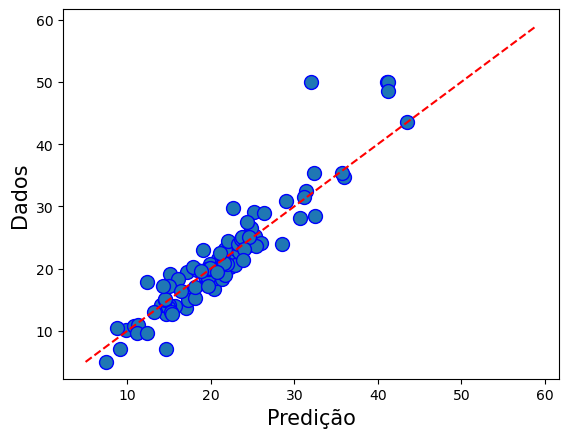

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure()
l = plt.plot(y_pred, y_test, 'bo')
plt.setp(l, markersize=10)
plt.setp(l, markerfacecolor='C0')

plt.ylabel("Dados", fontsize=15)
plt.xlabel("Predição", fontsize=15)

# mostra os valores preditos e originais
xl = np.arange(min(y_test), 1.2*max(y_test),(max(y_test)-min(y_test))/10)
yl = xl
plt.plot(xl, yl, 'r--')

plt.show(True)
# salva a figura em um arquivo
fig.savefig('regression.jpg')

Observamos que a regressão foi bastante adequada.

## Exercícios de fixação

Não é necessário entregar os exercícios abaixo, mas é importante resolvê-los para fixar os conteúdos estudados.

1 - Realize a classificação da base Vehicles usando validação cruzada e o método grid_search para escolher os melhores hiperparâmetros do modelo regressão logística e knn.

2 - Verifique se o número de folds, usado na validação cruzada, influencia na classificação da base winequality-red. Use o modelo de regressão logística.

3 - Repida a seleção do modelo de regressão na base Advertising.csv. 